# Lab Four - The Multi-Layer Perceptron
Hayden Center, Fidelia Nawar, Amory Weinzierl

In this lab, you will compare the performance of multi-layer perceptrons programmed  via your own various implementations. <br>

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. This lab project is slightly different from other reports in that you will be asked to complete more specific items.

<b>Dataset Selection</b>

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0 (Links to an external site.)

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/data (Links to an external site.) 

The classification task you will be performing is to predict, for each county, what the child poverty rate will be. You will need to convert this from regression to <b>four levels of classification</b> by quantizing the variable of interest. 

## Load, Split, and Balance (1.5 pts)

<ul>
    <li>[<b>.5 points</b>] Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the variables until asked to do so.  Remove any observations that having missing data. Encode any string data as integers for now. </li>
    <li>[<b>.5 points</b>] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing.</li>
    <li>[<b>.5 points</b>] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. <i>Should balancing of the dataset be done for both the training and testing set? Explain.</i></li>
</ul>

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

df = pd.read_csv('acs2017_census_tract_data.csv')

Pandas: 1.1.0
Numpy: 1.20.1


In [2]:
df.dropna(inplace=True)

In [3]:
df.select_dtypes(include='object')
from sklearn.preprocessing import LabelEncoder

# Encoding all of the string columns as integers
le = {}

for col in df.columns:
    if df[col].dtype == 'object':
        le[col] = LabelEncoder()
        df[col] = le[col].fit_transform(df[col])
        
# Categorizing columns into categorical columns, continuous 
# columns, and columns to be removed from the training set
remove_cols = ["ChildPoverty", "TractId", "County"]
cat_cols = ["State"]
cont_cols = list(df.columns)
for col in set(remove_cols + cat_cols):
    cont_cols.remove(col)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(remove_cols, axis=1)
y = df.ChildPoverty

X_train, X_test, y_train_values, y_test_values = train_test_split(X.to_numpy(), y.to_numpy(),
                                                                  test_size=.20, random_state=72)

labels = [0, 1, 2, 3]
y_train, bins = pd.qcut(y_train_values, q=4, retbins=True, labels=labels)
y_test = pd.cut(y_test_values, bins, include_lowest=True, labels=labels)

print(X_train.shape)
print(y_train_values.shape)
print(X_test.shape)
print(y_test_values.shape)

(58174, 34)
(58174,)
(14544, 34)
(14544,)


We decided to use Pandas' qcut function because it provides a simple way to balance the training data into 4 approximately equal classes and then apply those same class boundaries to the test data through the retbins option. Balancing should only ever be performed on the training data, not the testing data. Balancing the train and test data separately would innacurately classify the test data on the train data's class boundaries, which would reduce the accuracy. Balancing the entire dataset before splitting the train and test data will include the biases of the test data in training the model, which would then artificially increase the accuracy of the model on the test data specifically, without making the model any 'better' in terms of accuracy. Neither of these are good options, and so only the train data should be balanced.

## Pre-processing (2.5 pts)

<ul>
    <li>There are a number of version of the two layer perceptron covered in class. When using the example two layer network from class be sure that you use: (1) vectorized computation, (2) mini-batching, and (3) proper Glorot initialization, at a minimum.  </li>
    <li>[<b>.5 points</b>] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. </li>
    <li>[<b>.5 points</b>] Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  </li>
    <li>[<b>.5 points</b>] Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. </li>
    <li>[<b>1 points</b>] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.</li>  
        <ul>
            <li><i>Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.</i></li>
        </ul>
</ul>

In [5]:
from scipy.special import expit
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [6]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [7]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [8]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

Epoch: 20/20

CPU times: user 4.19 s, sys: 2.76 s, total: 6.95 s
Wall time: 3.51 s
Glorot Initial :
Resubstitution acc: 0.24925224327018944
Validation acc: 0.2523377337733773


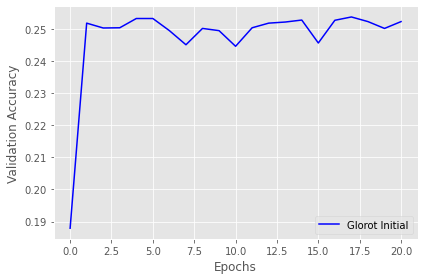

In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_better = TLPBetterInitial(**vals)

%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

Epoch: 20/20

CPU times: user 4.71 s, sys: 2.67 s, total: 7.38 s
Wall time: 3.73 s
Glorot Initial :
Resubstitution acc: 0.5681060267473442
Validation acc: 0.5672442244224423


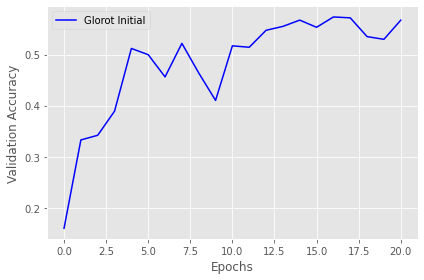

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X[cont_cols])

X_scaled = X.copy()
X_scaled[cont_cols] = scaler.transform(X[cont_cols])

X_train, X_test = train_test_split(X_scaled.to_numpy(), test_size=.20, random_state=72)

nn_better = TLPBetterInitial(**vals)

%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

Epoch: 20/20

CPU times: user 6.75 s, sys: 3.66 s, total: 10.4 s
Wall time: 5.27 s
Glorot Initial :
Resubstitution acc: 0.7251177501976828
Validation acc: 0.724009900990099


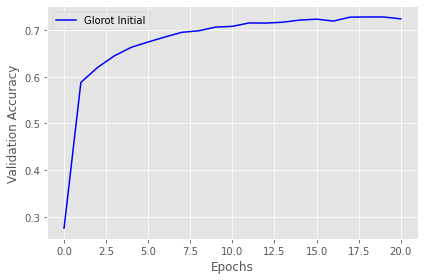

In [11]:
X_final = X_scaled.copy()

for col in cat_cols:
    X_final = pd.concat([X_final,pd.get_dummies(X_final[col], prefix=col)],axis=1)
    X_final.drop([col],axis=1, inplace=True)

X_train, X_test = train_test_split(X_final.to_numpy(), test_size=.20, random_state=72)

nn_better = TLPBetterInitial(**vals)

%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

These 3 models have very different performances. Before one-hot encoding the two categorical columns, the performance of the neural network was about as good as a random number generator. With an accuracy of around 25% for 4 classes, you could do about as well on the ACT by picking 'C' for every answer. The first classifier performs poorly from a combination of a high variation in feature scaling and the categorical data interfering with the prediction. Once the data is normalized, the issues with variation in feature scaling is essentially removed, because while it is technically an issue that the 'State' column will have a larger scale than all the others, the main issue with the state column is it being categorical. The model essentially starts using a state's position in the alphabet to predict the child poverty rate, since the state names were converted to integers from 0 to 49 in alphabetical order. This is obviously not a great way to predict the child poverty rate, and therefore lowers the accuracy quite a bit. Once those two issues were removed through normalization and one hot encoding the 'State' column, the network started to perform closer to how we would expect.

## Modeling (5 pts)

<ul>
    <li>[<b>1 points</b>] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.</li>
    <li>[<b>1 points</b>] Repeat the previous step, adding support for a fourth layer.</li>
    <li>[<b>1 points</b>] Repeat the previous step, adding support for a fifth layer. </li>
    <li>[<b>2 points</b>] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. </li>
</ul>

In [12]:
class MultiLayerPerceptronBase(object):   
    def __init__(self, n_layers=3, n_hidden=[30], C=0.0, epochs=200, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        WInitial = []
        
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        WInitial.append(W1)
        
        for idx in range(self.n_layers - 2):
            W_num_elems = (self.n_features_ + 1)*self.n_hidden
            W = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
            W = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
            WInitial.append(W)
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        
        WInitial.append(W2)
        
        return WInitial
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        totWeight = 0
        for w in W:
            totWeight += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(totWeight)
    
    def _feedforward(self, X, W):
        """Compute feedforward step"""
        A = []
        Z = []
        
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        
        A.append(A1)
        
        for idx in range(self.n_layers - 1):
            Z.append(W[idx] @ A[idx])
            Atemp = self._sigmoid(Z[idx])
            Atemp = self._add_bias_unit(Atemp, how='row')
            A.append(Atemp)
            
        Z.append(W[len(W) - 1] @ A[len(A) - 1])
        A.append(self._sigmoid(Z[len(Z) - 1]))
            
        return A, Z
    
    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X, self.W)
        y_pred = np.argmax(A[len(A) - 1], axis=0)
        return y_pred

In [13]:
class MLPMiniBatch(MultiLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1):
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        delta_W_prev = []
        for weight in self.W:
            delta_W_prev.append(np.zeros(weight.shape))

        self.cost_ = []
        self.score_ = []
        
        avgGrads = []
        for idx in range(self.n_layers):
                avgGrads.append([])
        
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for idx in range(self.epochs):
            #adaptive learning rate
            self.eta /= (1 + self.decrease_const*idx)

            if print_progress>0 and (idx+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (idx+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            grads = []
            for idx in range(self.n_layers):
                grads.append(0)
            
            for idx in mini:
                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, 
                                          Y_enc=Y_enc[:, idx], 
                                          W=self.W)
                
                for idx in range(len(grad)):
                    grads[idx] += np.mean(grad[idx])

                # momentum calculations
                delta_W = [g * self.eta for g in grad]
                
                for idx in range(len(delta_W)):
                    self.W[idx] -= (delta_W[idx] + (self.alpha * delta_W_prev[idx]))
                
                delta_W_prev = delta_W

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            for idx in range(len(avgGrads)):
                avgGrads[idx].append(grads[idx])
            
        return avgGrads

In [14]:
class MLPMiniBatchCrossEntropy(MLPMiniBatch):
    def _cost(self,A,Y_enc,W):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A)+(1-Y_enc)*np.log(1-A))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _get_gradient(self, A, Z, Y_enc, W):
        grad = []
        V1 = (A[len(A) - 1] - Y_enc)
        V2 = V1
        tempGrad = (V1 @ A[len(A) - 2].T)
        tempGrad[:, 1:] += W[len(W) - 1][:, 1:] * self.l2_C
        grad.append(tempGrad)
                
        for i in range(self.n_layers - 2):
            V = A[len(A) - i - 2]*(1 - A[len(A) - i - 2]) * (W[len(W) - i - 1].T @ V2)
            V2 = V[1:,:] 
            tempGrad = V[1:,:] @ A[len(A) - i - 3].T
            tempGrad[:, 1:] += W[len(W) - i - 2][:, 1:] * self.l2_C
            grad.insert(0, tempGrad)
            
        V = A[1]*(1 - A[1]) * (W[1].T @ V2)
        tempGrad = V[1:,:] @ A[0].T
        tempGrad[:, 1:] += W[0][:, 1:] * self.l2_C
        grad.insert(0, tempGrad)

        return grad

In [15]:
class MLPBetterInitial(MLPMiniBatchCrossEntropy):
    def __init__(self, n_layers=3, n_hidden=[30], C=0.0, epochs=200, eta=0.001, random_state=None,
                alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _initialize_weights(self):
        W = []
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden[0] + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden[0], self.n_features_ + 1))
        W1[:,:1] = 0
        W.append(W1)
        
        for idx in range(self.n_layers - 2):
            init_bound = 4*np.sqrt(6 / (self.n_hidden[idx + 1] + self.n_hidden[idx] + 1))
            WTemp = np.random.uniform(-init_bound, init_bound,(self.n_hidden[idx + 1], self.n_hidden[idx] + 1))
            WTemp[:,:1] = 0
            W.append(WTemp)
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden[self.n_layers - 2] + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden[self.n_layers - 2] + 1))
        W2[:,:1] = 0
        W.append(W2)
        
        return W

In [16]:
plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,grads, title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    for idx in range(len(grads)):
        plt.plot(range(len(grads[0])), grads[idx], label="grad_"+str(idx + 1))
    
    plt.ylabel('Average Magnitude of the Gradient')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

Epoch: 1/100

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7397462784061608
Validation acc: 0.7368674367436744


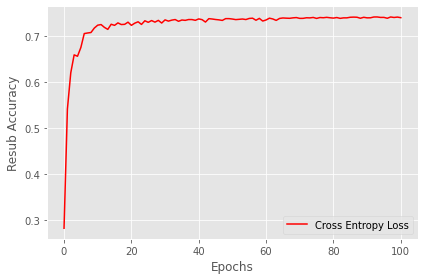

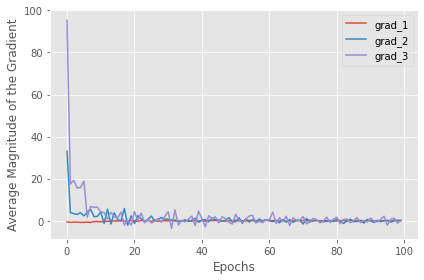

In [17]:
vals = { 'n_layers':3, 'n_hidden':[30, 25], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':0.0001, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn3 = MLPBetterInitial(**vals)

%time 
grads = nn3.fit(X_train, y_train, print_progress=1)

print_result(nn3,X_train,y_train, X_test, y_test,grads,title="Cross Entropy Loss",color="red")

Epoch: 1/100

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7429951524736137
Validation acc: 0.7398927392739274


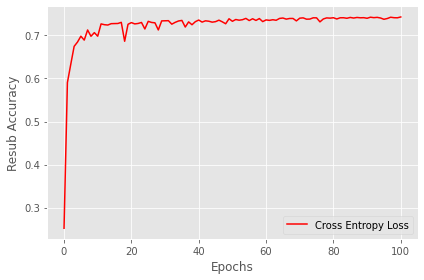

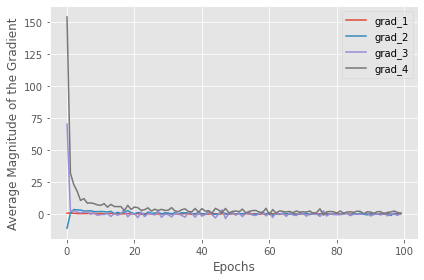

In [18]:
vals = { 'n_layers':4, 'n_hidden':[30, 25, 20], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':0.0001, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn4 = MLPBetterInitial(**vals)

%time
grads = nn4.fit(X_train, y_train, print_progress=1)

print_result(nn4,X_train,y_train, X_test, y_test,grads,title="Cross Entropy Loss",color="red")

Epoch: 1/100

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7405370096606732
Validation acc: 0.7374174917491749


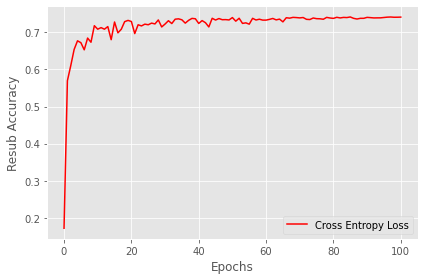

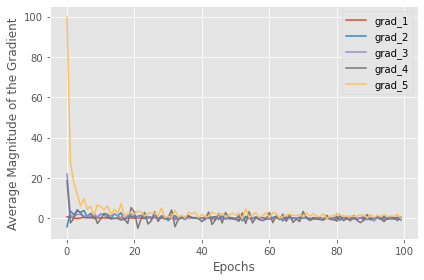

In [19]:
vals = { 'n_layers':5, 'n_hidden':[30, 25, 20, 15], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':0.0001, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn5 = MLPBetterInitial(**vals)

%time
grads = nn5.fit(X_train, y_train, print_progress=1)

print_result(nn5,X_train,y_train, X_test, y_test,grads,title="Cross Entropy Loss",color="red")

In [20]:
#no adaptive learning
class MLPwithoutAL(MLPBetterInitial):
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        #get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        g1 = []
        for idx in range(self.n_layers):
                g1.append([])
        
        for idx in range(self.epochs):
            #removed adaptive learning rate
            if print_progress>0 and (idx+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (idx+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            g2 = []
            for idx in range(self.n_layers):
                g2.append(0)
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                
                for idx in range(len(grad)):
                    g2[idx] += np.mean(grad[idx])
                
                #momentum calculations
                delta_W = [i * self.eta for i in grad]
                
                for idx in range(len(delta_W)):
                    self.W[idx] -= delta_W[idx]
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            for idx in range(len(g1)):
                g1[idx].append(g2[idx])
            
        return g1

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.39 µs


Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7412761714855434
Validation acc: 0.7397552255225522


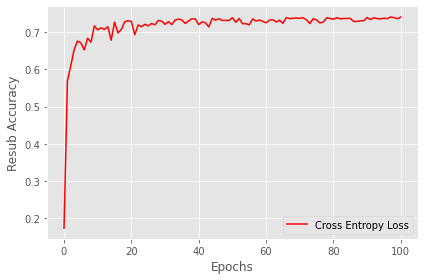

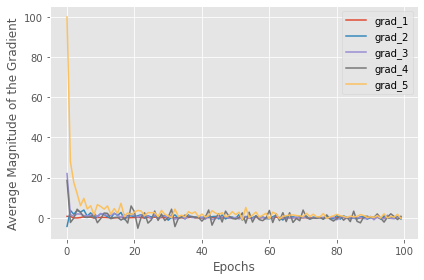

In [21]:
vals = { 'n_layers':5, 'n_hidden':[30, 25, 20, 15], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':0.0001, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn6 = MLPwithoutAL(**vals)

%time
grads = nn6.fit(X_train, y_train, print_progress=1)

print_result(nn6,X_train,y_train, X_test, y_test,grads,title="Cross Entropy Loss",color="red")

The five layer network model with adaptive learning has a higher rate -- although very slight -- than the five layer network model without adaptive learning in both resubstitution accuracy and validation accuracy. Adaptive learning is meant to optimize neural nets so a higher accuracy rate in both resubsitution and validation is to be expected.

## Exceptional Work (1 pts)

<ul>
    <li>5000 level student: You have free reign to provide additional analyses.</li>
    <li>One idea (<b>required for 7000 level students</b>):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance. </li>
</ul>

In [22]:
class MLP_AdaM(MLPBetterInitial):
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwds):        
        #adam decay rate of moment
        self.beta1 = beta1
        #adam decay rate of moment
        self.beta2 = beta2
        #adam numerical stabilizer
        self.epsilon = epsilon
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        self.cost_ = []
        self.score_ = []
        #get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        g1 = []
        for idx in range(self.n_layers):
                g1.append([])
        
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            g2 = []
            for index in range(self.n_layers):
                g2.append(0)
                
            m = [0] * len(mini)
            r = [0] * len(mini)
            
            for idx,iterator in zip(mini,range(len(mini))):

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[len(A) - 1],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx], W=self.W)
                
                for index in range(len(grad)):
                    g2[index] += np.mean(grad[index])

                #https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/
                #the above source was referenced in regard to implementing the bias correction
                #mechanisms in the below for loop
                for k in range(len(g2)):
                    if k == 0:
                        delta_W = [i * self.eta for i in grad]
                        
                        for j in range(len(delta_W)):
                            self.W[j] -= delta_W[j]
                    else:
                        m[iterator] = self.beta1 * m[iterator] + (1 - self.beta1) * g2[index]
                        r[iterator] = self.beta2 * r[iterator] + (1 - self.beta2) * np.power(g2[index], 2)
                        
                        m_k_hat = m[iterator] / (1 - np.power(self.beta1, k))
                        r_k_hat = r[iterator] / (1 - np.power(self.beta2, k))
                        
                        self.W[k] -= ((self.eta * m_k_hat) / (np.sqrt(r_k_hat) + self.epsilon))

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            for index in range(len(g1)):
                g1[index].append(g2[index])
            
        return g1

Epoch: 100/100

Cross Entropy Loss :
Resubstitution acc: 0.7429263932340908
Validation acc: 0.7405115511551155


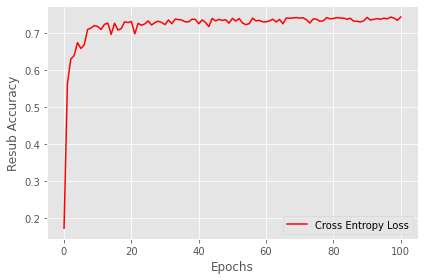

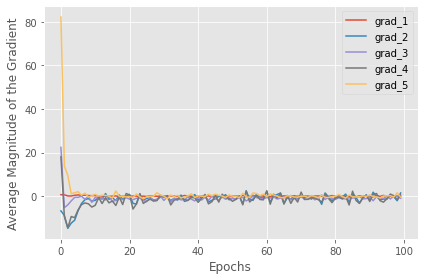

In [23]:
vals = { 'n_layers':5, 'n_hidden':[30, 25, 20, 15], 
         'C':0.1, 'epochs':100, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1, 'epsilon':1e-8}

nn7 = MLP_AdaM(**vals)

grads = nn7.fit(X_train, y_train, print_progress=1)

print_result(nn7,X_train,y_train, X_test, y_test,grads,title="Cross Entropy Loss",color="red")

Comparing the visuals of the AdaM representation vs the one without adaptive learning, we can see how graphs of each look very similar, but the accuracy percentages are slightly different. Looking at the table, we can compare both accuraces side by side:

|               | Resubstitution Accuracy  | Validation Accuracy |
| -----------   | ----------- -----------  | --------------------|
| Non-Adaptive  | 0.7412761714855434       | 0.7397552255225522  |
| AdaM          | 0.7429263932340908       | 0.7405115511551155  |



AdaM had slightly higher accuracies than the non-adaptive. This is because AdaM is an optimizer - it is a method that computes adaptive learning rates for each parameter. It can be considered as a combination of RMSprop and Stochastic Gradient Descent with momentum because it uses the squared gradients to scale the learning rate like RMSprop, and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. In addition to storing an exponentially decaying average of past squared gradients <i>s</i>, AdaM also keeps an exponentially decaying average of past gradients <i>v</i>, similar to momentum. AdaM prefers flat minima in the error surface, which is why it is expected that combining this method with the five layer neural network yields higher accuracies.